In [72]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from py2neo import Node, Graph, Relationship, NodeMatcher
from py2neo.bulk import merge_nodes
from neo4j import GraphDatabase

import numpy as np
import pandas as pd
import wikipedia

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.matcher import Matcher
from spacy.tokens import Doc, Span, Token

from pywikibot.data import api
import pywikibot
import wikipedia
import pprint

print(spacy.__version__)

3.0.3


In [2]:
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
VERBS = ['ROOT', 'advcl']
OBJECTS = ["dobj", "dative", "attr", "oprd", 'pobj']
ENTITY_LABELS = ['PERSON', 'NORP', 'GPE', 'ORG', 'FAC', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART']

non_nc = spacy.load('en_core_web_md')

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('merge_noun_chunks')

print(non_nc.pipe_names)
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'merge_noun_chunks']


In [3]:
text = wikipedia.summary('barack obama')
doc = nlp(text)
text

'Barack Hussein Obama II ( (listen) bə-RAHK hoo-SAYN oh-BAH-mə; born August 4, 1961) is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, Obama was the first African-American  president of the United States. He previously served as a U.S. senator from Illinois from 2005 to 2008 and as an Illinois state senator from 1997 to 2004.\nObama was born in Honolulu, Hawaii. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduating, he became a civil rights attorney and an academic, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. Turning to elective politics, he represented the 13th district in the Illinois Senate from 1997 until 2004, when he ran for the U.S. Senate. Obama received national attention 

In [4]:
spacy.displacy.serve(doc, style='ent')

/opt/conda/lib/python3.8/site-packages/spacy/displacy/__init__.py:97: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [5]:
ent_ignore_ls = ['DATE']
ner_list = []

for el in doc.ents:
    if el.label_ not in ent_ignore_ls:
        #print(el, el.label_)
        if el.text not in ner_list:
            temp_doc = nlp(el.text)
            ner_list.append(el.text)

ner_list[0:5]

['Barack Hussein Obama II',
 'the United States',
 'the Democratic Party',
 'Obama',
 'Illinois']

In [6]:
def remove_special_characters(text):
    
    regex = re.compile(r'[\n\r\t]')
    clean_text = regex.sub(" ", text)
    
    return clean_text


def remove_stop_words_and_punct(text, print_text=False):
    
    result_ls = []
    rsw_doc = non_nc(text)
    
    for token in rsw_doc:
        if print_text:
            print(token, token.is_stop)
            print('--------------')
        if not token.is_stop and not token.is_punct and not token.is_space:
            result_ls.append(str(token))
    
    result_str = ' '.join(result_ls)

    return result_str

In [7]:
node_text_ls = []

for el in ner_list:
    clean_text = remove_special_characters(el)
    no_sw = remove_stop_words_and_punct(clean_text)
    if no_sw not in node_text_ls:
        node_text_ls.append(no_sw)

node_text_ls

['Barack Hussein Obama II',
 'United States',
 'Democratic Party',
 'Obama',
 'Illinois',
 'Honolulu',
 'Hawaii',
 'Columbia University',
 'Chicago',
 'Harvard Law School',
 'Harvard Law Review',
 'University Chicago Law School',
 'U.S. Senate',
 'Senate',
 'Hillary Clinton',
 'Republican nominee John McCain',
 'Joe Biden',
 'Affordable Care Act',
 'ACA',
 'Obamacare',
 'American Recovery Reinvestment Act',
 'Great Recession',
 'Budget Control',
 'American Taxpayer Relief Acts',
 'Afghanistan',
 'Iraq War',
 'Libya',
 'Muammar Gaddafi',
 'Osama bin Laden',
 'Republican opponent Mitt Romney',
 'LGBT Americans',
 'Supreme Court',
 'Windsor',
 'Obergefell',
 'Hodges',
 'Court',
 'Iraq',
 'Syria',
 'ISIL',
 '2015 Paris Agreement',
 'Russia',
 'Ukraine',
 'Iran',
 'Cuba',
 'Sonia Sotomayor',
 'Elena Kagan',
 'Merrick Garland',
 'Republican led Senate',
 'Mitch McConnell',
 'Washington',
 'D.C.During']

In [8]:
def getItems(site, itemtitle):
    params = { 'action' :'wbsearchentities' , 'format' : 'json' , 'language' : 'en', 'type' : 'item', 'search': itemtitle}
    request = api.Request(site=site,**params)
    return request.submit()

def getItem(site, wdItem, token):
    request = api.Request(site=site,
                          action='wbgetentities',
                          format='json',
                          ids=wdItem)    
    return request.submit()

def prettyPrint(variable):
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(variable)

# Login to wikidata
token = open('.wiki_api_token').read()
wikidata = pywikibot.Site('wikidata', 'wikidata')
site = pywikibot.Site("wikidata", "wikidata")

In [9]:
itempage = pywikibot.ItemPage(wikidata, "Q76")  # Q42 is Douglas Adams
itempage

ItemPage('Q76')

In [10]:
item_ls = []
i = 0

for el in node_text_ls:
    #itempage = pywikibot.ItemPage(wikidata, el)
    #print(el, itempage)
    wikidataEntries = getItems(site, el)
    try:
        tup = (wikidataEntries['search'][0]['id'], el)
        item_ls.append(tup)
    except:
        i += 1
        print('Missing ', i,'th entry for ', el)
    #item_ls.append(tup)
    
dedup_item_ls = []

for item in item_ls:
    if item not in dedup_item_ls:
        dedup_item_ls.append(item)
        
dedup_item_ls

  request = api.Request(site=site,**params)



Missing  1 th entry for  University Chicago Law School
Missing  2 th entry for  Republican nominee John McCain
Missing  3 th entry for  American Recovery Reinvestment Act
Missing  4 th entry for  American Taxpayer Relief Acts
Missing  5 th entry for  Republican opponent Mitt Romney
Missing  6 th entry for  LGBT Americans
Missing  7 th entry for  2015 Paris Agreement
Missing  8 th entry for  Republican led Senate
Missing  9 th entry for  D.C.During


[('Q76', 'Barack Hussein Obama II'),
 ('Q30', 'United States'),
 ('Q29552', 'Democratic Party'),
 ('Q76', 'Obama'),
 ('Q1204', 'Illinois'),
 ('Q18094', 'Honolulu'),
 ('Q782', 'Hawaii'),
 ('Q49088', 'Columbia University'),
 ('Q1297', 'Chicago'),
 ('Q49122', 'Harvard Law School'),
 ('Q1365125', 'Harvard Law Review'),
 ('Q66096', 'U.S. Senate'),
 ('Q637846', 'Senate'),
 ('Q6294', 'Hillary Clinton'),
 ('Q6279', 'Joe Biden'),
 ('Q1414593', 'Affordable Care Act'),
 ('Q1414593', 'ACA'),
 ('Q1414593', 'Obamacare'),
 ('Q154510', 'Great Recession'),
 ('Q4985020', 'Budget Control'),
 ('Q889', 'Afghanistan'),
 ('Q545449', 'Iraq War'),
 ('Q1016', 'Libya'),
 ('Q19878', 'Muammar Gaddafi'),
 ('Q1317', 'Osama bin Laden'),
 ('Q11201', 'Supreme Court'),
 ('Q182625', 'Windsor'),
 ('Q19866992', 'Obergefell'),
 ('Q21337810', 'Hodges'),
 ('Q41487', 'Court'),
 ('Q796', 'Iraq'),
 ('Q858', 'Syria'),
 ('Q2429253', 'ISIL'),
 ('Q159', 'Russia'),
 ('Q212', 'Ukraine'),
 ('Q794', 'Iran'),
 ('Q241', 'Cuba'),
 ('Q11107

In [11]:
%%time
p_dc = {'P6': 'head_of_government',
        'P17': 'country',
        'P19': 'place_of_birth',
        'P22': 'father',
        'P25': 'mother', 
        'P26': 'spouse',
        'P27': 'country_of_citizenship',
        'P30': 'continent',
        'P31': 'instance_of',
        'P35': 'head_of_state',
        'P36': 'capital',
        'P37': 'official_language',
        'P39': 'position_held',
        'P40': 'child',
        'P69': 'educated_at',
        'P101': 'field_of_work',
        'P102': 'member_of_political_party',
        'P106': 'occupation',
        'P108': 'employer',
        'P150': 'contains_administrative_territorial_entity',
        'P159': 'headquarters_location',
        'P166': 'award_received',
        'P172': 'ethnic_group',
        'P361': 'part_of',
        'P463': 'member_of',
        'P551': 'residence',
        'P607': 'conflict',
        'P793': 'significant_event',
        'P1344': 'participated_in',
        'P1813': 'short_name',
        'P1906': 'office_held_by_head_of_state',
        'P2388': 'office_held_by_head_of_the_organization',
        'P2670': 'has_parts_of_the_class'
       }

full_node_tup_ls = []

for el in tqdm(item_ls):
    itempage = pywikibot.ItemPage(wikidata, el[0])
    itemdata = itempage.get()
    source_node = itemdata['labels']['en']
    #print(el, source_node)

    for key in p_dc.keys():
        #print(source_node, key, p_dc[key])
        #print(itemdata['claims'])
        try:
            for i in itemdata['claims'][key]:
                target = i.getTarget()
                #print(target.id)
                tup = (source_node, el[0], key, p_dc[key], target.labels['en'], target.id)
                if tup not in full_node_tup_ls:
                    full_node_tup_ls.append(tup)
        except:
            continue

#full_node_tup_ls

100%|██████████| 42/42 [09:53<00:00, 14.14s/it]

CPU times: user 39.4 s, sys: 592 ms, total: 40 s
Wall time: 9min 53s


In [12]:
df = pd.DataFrame(full_node_tup_ls, columns=['source_name', 'source_q', 'rel_p', 'rel_name', 'target_name', 'target_q'])
df.head()

,source_name,source_q,rel_p,rel_name,target_name,target_q
0,Barack Obama,Q76,P19,place_of_birth,Kapiolani Medical Center for Women and Children,Q6366688
1,Barack Obama,Q76,P19,place_of_birth,Kenya,Q114
2,Barack Obama,Q76,P22,father,Barack Obama Sr.,Q649593
3,Barack Obama,Q76,P25,mother,Ann Dunham,Q766106
4,Barack Obama,Q76,P26,spouse,Michelle Obama,Q13133


In [13]:
df.shape

(1628, 6)

In [17]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [18]:
conn = Neo4jConnection(uri="bolt://neo4j:7687", user="neo4j", pwd="kgDemo")

In [19]:
conn.query('CREATE CONSTRAINT q_value IF NOT EXISTS ON (n:Node) ASSERT n.id IS UNIQUE')

[]

In [20]:
source_df = df[['source_name', 'source_q']].drop_duplicates()
source_df.columns = ['name', 'id']
target_df = df[['target_name', 'target_q']].drop_duplicates()
target_df.columns = ['name', 'id']
all_nodes_df = pd.concat([source_df, target_df]).drop_duplicates()
all_nodes_df.shape

(1318, 2)

In [21]:
def get_p31(row):
    # P31 corresponds to "instance of"
    
    itempage = pywikibot.ItemPage(wikidata, row)
    itemdata = itempage.get()
    try:
        target = itemdata['claims']['P31'][0].getTarget()
        target.get()
        return target.labels['en']
    except:
        return 'Unknown'
    

def add_nodes(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
               MERGE (:Node {name: row.name, id: row.id, type: row.node_label})
               RETURN count(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_edges(rows, batch_size=50000):
    
    
    query = """UNWIND $rows AS row
               MATCH (src:Node {id: row.source_q}), (tar:Node {id: row.target_q})
               CREATE (src)-[:%s]->(tar)
    """ % edge
    
    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        try:
            total += res[0]['total']
        except:
            total += 0
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [22]:
%%time
all_nodes_df['node_label'] = all_nodes_df['id'].map(get_p31)
all_nodes_df.head()

CPU times: user 36.5 s, sys: 617 ms, total: 37.2 s
Wall time: 12min 16s


,name,id,node_label
0,Barack Obama,Q76,human
72,United States of America,Q30,sovereign state
318,Democratic Party,Q29552,political party
323,Illinois,Q1204,state of the United States
435,Honolulu,Q18094,county seat


In [23]:
add_nodes(all_nodes_df)

{'total': 1318, 'batches': 1, 'time': 0.5529170036315918}


{'total': 1318, 'batches': 1, 'time': 0.5529170036315918}

In [24]:
edge_ls = df['rel_name'].unique().tolist()
#edge_ls

In [25]:
for edge in edge_ls:
    print(edge)
    y = df[df['rel_name'] == edge]
    #print(y.shape)
    add_edges(y)

place_of_birth
{'total': 0, 'batches': 1, 'time': 0.10903286933898926}
father
{'total': 0, 'batches': 1, 'time': 0.035398244857788086}
mother
{'total': 0, 'batches': 1, 'time': 0.03559255599975586}
spouse
{'total': 0, 'batches': 1, 'time': 0.037001609802246094}
country_of_citizenship
{'total': 0, 'batches': 1, 'time': 0.0357668399810791}
instance_of
{'total': 0, 'batches': 1, 'time': 0.05239558219909668}
position_held
{'total': 0, 'batches': 1, 'time': 0.03542184829711914}
child
{'total': 0, 'batches': 1, 'time': 0.034018516540527344}
educated_at
{'total': 0, 'batches': 1, 'time': 0.03552889823913574}
field_of_work
{'total': 0, 'batches': 1, 'time': 0.0306549072265625}
member_of_political_party
{'total': 0, 'batches': 1, 'time': 0.029277563095092773}
occupation
{'total': 0, 'batches': 1, 'time': 0.03223013877868652}
employer
{'total': 0, 'batches': 1, 'time': 0.029970884323120117}
award_received
{'total': 0, 'batches': 1, 'time': 0.03991246223449707}
ethnic_group
{'total': 0, 'batches'

In [35]:
y = all_nodes_df['node_label'].value_counts()
print(y[0:5])

human                         218
county of Illinois            102
Unknown                        56
state of the United States     50
oblast of Russia               45
Name: node_label, dtype: int64


In [37]:
query_string = '''
    MATCH (n:Model_Data)
    RETURN n.name, n.type, 1 AS category, n.n2v10_all_nodes AS vec
'''
model_data_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
model_data_df.head()

,n.name,n.type,category,vec
0,United States of America,sovereign state,1,None
1,Democratic Party,political party,1,None
2,Illinois,state of the United States,1,None
3,Hawaii,state of the United States,1,None
4,Chicago,city of the United States,1,None


In [38]:
model_data_df.shape

(823, 4)

In [39]:
vec_np = model_data_df['vec'].to_numpy()
y = model_data_df['category'].to_numpy()
vec_np.shape

(823,)

In [64]:
def create_tsne_plot(emb_name='n.n2v_all_nodes', n_components=2, debug=False):
    
    query_string = '''
        MATCH (n:Model_Data)
        RETURN n.name, n.type, n.is_place AS category, {} AS vec
    '''.format(emb_name)
    model_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
    
    if debug:
        uniqueValues = model_df['category'].nunique()
        print(uniqueValues)
    
    X_emb = TSNE(n_components=n_components).fit_transform(list(model_df['vec']))
    
    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb],
        'label': model_df['category']
    })
    
    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls',2),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=500,
        alpha=0.75
    )
    ax.legend(prop={'size': 20})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show

    return tsne_df

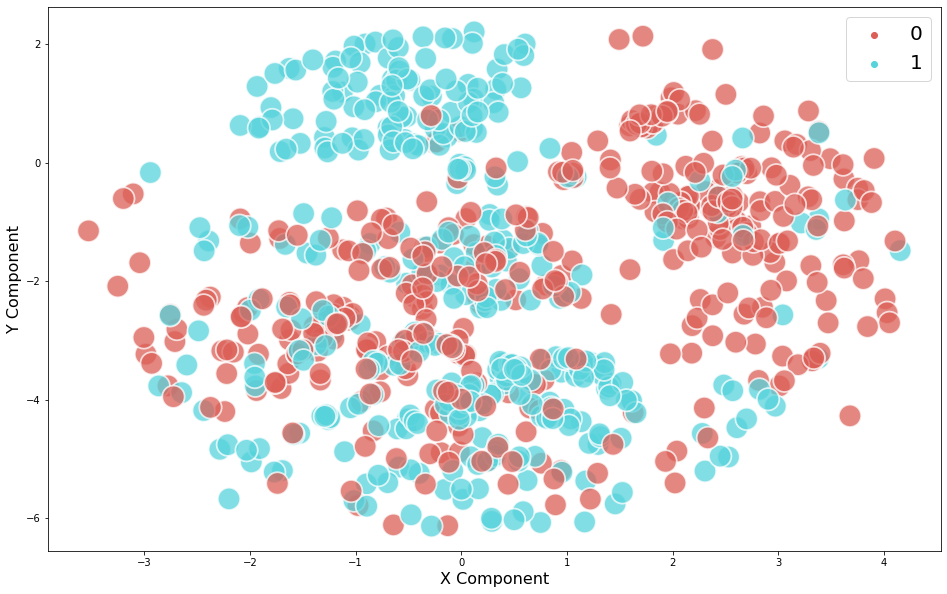

In [65]:
tsne_df = create_tsne_plot(emb_name='n.n2v_all_nodes', n_components=2, debug=False)

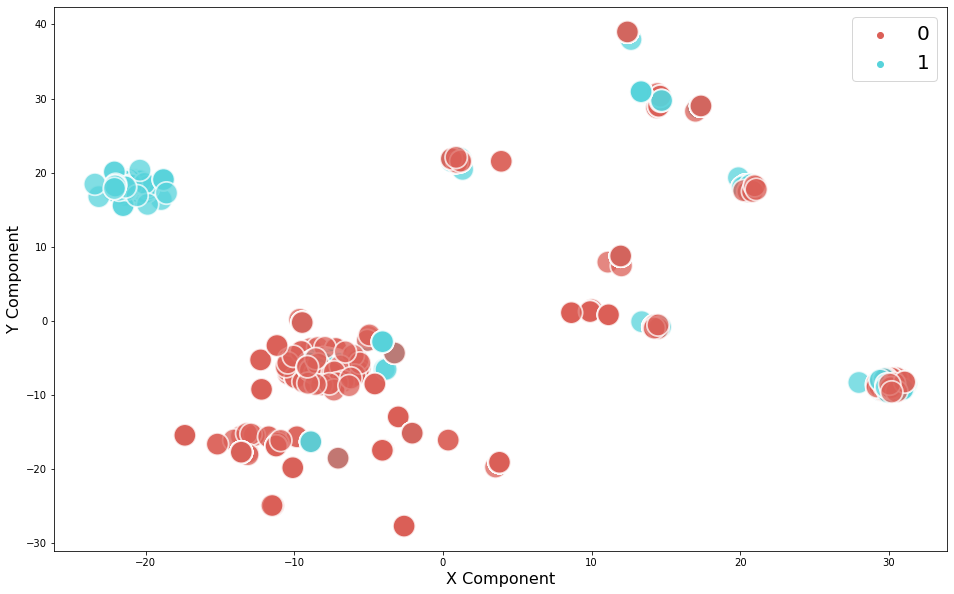

In [68]:
tsne_df = create_tsne_plot(emb_name='n.frp_all_nodes', n_components=2, debug=False)

In [93]:
query_string = '''
    MATCH (n:Model_Data)
    RETURN n.name, n.type, n.is_place AS category, n.n2v_all_nodes AS n2v_vec, n.frp_all_nodes AS frp_vec
'''
model_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
model_df.head()

,n.name,n.type,category,n2v_vec,frp_vec
0,United States of America,sovereign state,1,"[0.06254410743713379, 0.2595505714416504, -0.1...","[0.21622970700263977, 0.1671326756477356, -0.0..."
1,Democratic Party,political party,0,"[0.1259424239397049, 0.22953206300735474, -0.3...","[0.10498179495334625, 0.017325039952993393, -0..."
2,Illinois,state of the United States,1,"[-0.06240788474678993, -0.3062209486961365, -0...","[0.06931227445602417, 0.11020652204751968, -0...."
3,Hawaii,state of the United States,1,"[0.11160175502300262, -0.0274458397179842, -0....","[0.16305188834667206, 0.13411904871463776, 0.0..."
4,Chicago,city of the United States,1,"[0.09670834988355637, -0.013175737112760544, -...","[0.2338847666978836, -0.04192311689257622, 0.0..."


In [76]:
X = model_df['vec']
y = model_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [95]:
def create_X(df2, emb):

    n2v_an_ls = df2[emb].to_list()
    n2v_arr = np.array([np.array(x) for x in n2v_an_ls], dtype=object)

    print(n2v_arr.shape)
    
    return n2v_arr


def modeler(df, emb_name, y_column_name, k_folds=5, model='linear', show_matrix=True):
    
    y = df[y_column_name].fillna(0.0).to_numpy()
    vec_array = create_X(df, emb_name)
    acc_scores = []
    
    pos = np.count_nonzero(y == 1.0)
    neg = y.shape[0] - pos
    print('Number of positive: ', pos, ' Number of negative: ', neg)
    
    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(vec_array, y, test_size=0.25)
        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return clf

(823, 300)
Number of positive:  413  Number of negative:  410
Accuracy scores:  [0.6067961165048543, 0.6456310679611651, 0.6747572815533981, 0.6844660194174758, 0.6262135922330098]
Mean accuracy:  0.6475728155339805


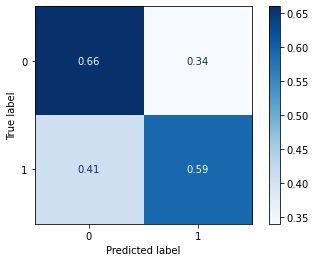

In [96]:
n2v_clf = modeler(model_df, emb_name='n2v_vec', y_column_name='category')

(823, 300)
Number of positive:  413  Number of negative:  410
Accuracy scores:  [0.7669902912621359, 0.7281553398058253, 0.7427184466019418, 0.7475728155339806, 0.7621359223300971]
Mean accuracy:  0.7495145631067961


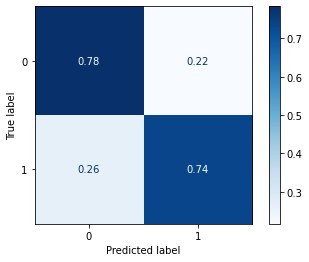

In [97]:
frp_clf = modeler(model_df, emb_name='frp_vec', y_column_name='category')

In [ ]:
query_string = '''
    
'''